## Insights from Visualization

- Train generator 1 -> Just not enough data to say anything
- Train generator 2 -> acce ts based 250ms cutline data. 553753 rows with only 10 sites, smallest wps count for site_floor is 3 with actual records 42, whereas the highest wps count is 835 with actual records 11724. It converges well with good accuracy. -> rmse_x: 0.61 rmse_y: 0.66 rmse_f: 0.017, comp metric at 0.67 -> But has no sites that are in the submission sites, so bad submission score
- Train generator 3 -> wps ts based with no cutline. 166681 rows with all 204 sites. It just doesn’t converge though -> rmse_x: 24.6 rmse_y: 21.8 rmse_f: 0.41 with comp metric at 30.1 -> Too large.
- Train generator 3M ->modify version 3 to only the 24 sites -> reduced to 75278 rows -> Still doesn’t converge. rmse_x: 23.8 rmse_y: 21.6 rmse_f: 0.36, comp metric at 29.6. -> Too large. Only wps maybe just isn't enough

- Train generator 2.1 -> acce_uncali ts based 100ms cutline data. Should cover all 204 site. Reduced to 100ms cutline because memory just won't hold.

In [129]:
import os
import json
import glob
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objs as go

from PIL import Image, ImageOps
from skimage import io
from skimage.color import rgba2rgb, rgb2xyz
from tqdm import tqdm
from dataclasses import dataclass
from math import floor, ceil
import random

# Train data generation
import collections
import csv
from pathlib import Path
from typing import List, Tuple, Any

import time
import re
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import pickle

import math

pd.set_option("display.max_columns", 100)

In [130]:
!cp -r ../input/indoorlocationgithub/* ./

In [131]:
from io_f import read_data_file
from compute_f import compute_step_positions, compute_steps, \
compute_headings, compute_stride_length, compute_step_heading, compute_rel_positions, split_ts_seq

In [132]:
SEED = 42

In [133]:
# !ls -la -h ../input/indoor2ndtrain

In [166]:
# train2 had better score even if it covered only 10 sites
# create similar dataset to train2 but with all the sites
# but maybe we just only got 10 sites for a reason (no acce_uncali etc)

# train_file_name = "../input/indoorfulltestgroupedtrain/indoor_train_2_site_group.pkl"
train_file_name = "../input/indoor3rdtrain/indoor_train_3.pkl"
# train_file_name = "../input/indoor2ndtrain/indoor_train_2.pkl"
test_file_name = "../input/indoorfulltestgroupedtrain/indoor_test_2_250ms.pkl"
# dir_path = "../input/indoorpkl/"
# dir_path = "../input/indoorpkl/"

# Load data it back in
with open(train_file_name, "rb") as file:
    df_train = pickle.load(file)

with open(test_file_name, "rb") as file:
    df_test = pickle.load(file)
    
# Get submission file
sub_df = pd.read_csv("/kaggle/input/indoor-location-navigation/sample_submission.csv")
sub_df[["site", "file", "timestamp"]] = sub_df["site_path_timestamp"].apply(lambda x: pd.Series(x.split("_")))
sub_df = sub_df.drop(columns=["floor", "x", "y"])

In [167]:
print(len(df_train))
display(df_train.head())
display(df_test.head())
display(sub_df.head())
print(sub_df["site"].nunique())

166681


,site_id,file_id,floor_converted,floor,ts,start_ts,diff_start_ts,x,y,closest_wp_ts,diff_start_wp_ts,diff_ts_wp_ts,within_100ms,within_200ms,acce_ts,diff_acce_ts,acce_x,acce_y,acce_z,acce_acc,ahrs_ts,diff_ahrs_ts,ahrs_x,ahrs_y,ahrs_z,ahrs_acc,magn_ts,diff_magn_ts,magn_x,magn_y,magn_z,magn_acc,magn_strength,gyro_ts,diff_gyro_ts,gyro_x,gyro_y,gyro_z,gyro_acc,acce_u_ts,diff_acce_u_ts,acce_u_x,acce_u_y,acce_u_z,acce_u_acc,magn_u_ts,diff_magn_u_ts,magn_u_x,magn_u_y,magn_u_z,magn_u_acc,gyro_u_ts,diff_gyro_u_ts,gyro_u_x,gyro_u_y,gyro_u_z,gyro_u_acc,wifi_ts,diff_wifi_ts,wifi_ssid,wifi_bssid,wifi_rssi,wifi_freq,wifi_last_seen_ts,beacon_ts,diff_beacon_ts,beacon_ssid,beacon_rssi,rel_ts,diff_rel_ts,rel_x,rel_y,site_id_le,file_id_le,floor_le,wifi_ssid_le,wifi_bssid_le,beacon_ssid_le,ts_date,ts_day,ts_hour,ts_minute,wifi_last_seen_ts_date,wifi_last_seen_ts_day,wifi_last_seen_ts_hour,wifi_last_seen_ts_minute
0,5cd56c11e2acfd2d33b6b413,5d0a28ea096be600087ee559,4.0,F5,1.560947e+12,1.560947e+12,1.0,58.555584,99.836440,NaN,NaN,NaN,NaN,NaN,1.560947e+12,123.0,2.164307,3.568893,9.806992,NaN,1.560947e+12,123.0,0.133892,0.147807,0.974019,NaN,1.560947e+12,123.0,1.680000,-29.580000,-12.840000,NaN,32.290314,1.560947e+12,123.0,0.628174,0.762878,-0.085388,NaN,1.560947e+12,123.0,2.488541,3.444473,9.980469,NaN,1.560947e+12,123.0,0.420000,-82.200000,-156.59999,NaN,1.560947e+12,123.0,0.623077,0.808777,-0.158813,NaN,1.560947e+12,642.0,3179f4bf7224dced6eb4c032dcd06f2ea71a5ba0,8788fab8673e3fb9c4ee2e243defd6da04db7e17,-72.0,NaN,1.560947e+12,1.560947e+12,197.0,89cb11b04122cef23388b0da06bd426c1f48a9b5_cfc84...,-87.0,1.560947e+12,969.0,-0.124440,-0.402672,93,11350,20,1744,15004,10751,2019-06-19 12:18:59.196000000,2019-06-19,2019-06-19 12:00:00,2019-06-19 12:18:00,2019-06-19 12:18:49.288999936,2019-06-19,2019-06-19 12:00:00,2019-06-19 12:18:00
1,5cd56c11e2acfd2d33b6b413,5d0a28ea096be600087ee559,4.0,F5,1.560947e+12,1.560947e+12,11969.0,66.170590,85.414116,NaN,NaN,NaN,NaN,NaN,1.560947e+12,11972.0,0.800400,1.854446,9.540192,NaN,1.560947e+12,11972.0,-0.026937,0.156391,0.928714,NaN,1.560947e+12,11972.0,-14.520000,-15.000000,-30.179998,NaN,36.696903,1.560947e+12,11972.0,-0.255722,-0.009247,0.282333,NaN,1.560947e+12,11972.0,0.640091,1.733612,9.647858,NaN,1.560947e+12,11972.0,-15.780000,-67.619995,-173.93999,NaN,1.560947e+12,11972.0,-0.328018,0.073303,0.222351,NaN,1.560947e+12,11841.0,3179f4bf7224dced6eb4c032dcd06f2ea71a5ba0,8788fab8673e3fb9c4ee2e243defd6da04db7e17,-54.0,NaN,1.560947e+12,1.560947e+12,11575.0,0e570c3406b79266b7ada12e3b9314e7bb9dde3e_f4a01...,-71.0,1.560947e+12,11696.0,-0.466097,-0.539031,93,11350,20,1744,15004,2927,2019-06-19 12:19:11.164000000,2019-06-19,2019-06-19 12:00:00,2019-06-19 12:19:00,2019-06-19 12:19:10.468000000,2019-06-19,2019-06-19 12:00:00,2019-06-19 12:19:00
2,5cd56c11e2acfd2d33b6b413,5d0a28e924caf50008a4f241,4.0,F5,1.560947e+12,1.560947e+12,0.0,39.006012,97.943690,NaN,NaN,NaN,NaN,NaN,1.560947e+12,130.0,1.058838,2.773285,8.855835,NaN,1.560947e+12,130.0,-0.047736,-0.147921,-0.987703,NaN,1.560947e+12,130.0,-3.780000,-21.720000,-26.640000,NaN,34.579422,1.560947e+12,130.0,-0.007111,0.353607,1.296356,NaN,1.560947e+12,130.0,0.963120,2.782852,9.098709,NaN,1.560947e+12,130.0,-1.020000,-73.200000,-173.87999,NaN,1.560947e+12,130.0,-0.012207,0.399506,1.222931,NaN,1.560947e+12,606.0,3179f4bf7224dced6eb4c032dcd06f2ea71a5ba0,8788fab8673e3fb9c4ee2e243defd6da04db7e17,-79.0,NaN,1.560947e+12,1.560947e+12,8824.0,89cb11b04122cef23388b0da06bd426c1f48a9b5_cfc84...,-70.0,1.560947e+12,819.0,0.100965,-0.486124,93,11349,20,1744,15004,10751,2019-06-19 12:17:24.368000000,2019-06-19,2019-06-19 12:00:00,2019-06-19 12:17:00,2019-06-19 12:17:15.960000000,2019-06-19,2019-06-19 12:00:00,2019-06-19 12:17:00
3,5cd56c11e2acfd2d33b6b413,5d0a28e924caf50008a4f241,4.0,F5,1.560947e+12,1.560947e+12,10176.0,44.875984,86.008270,NaN,NaN,NaN,NaN,NaN,1.560947e+12,10168.0,-0.439087,2.589035,8.774490,NaN,1.560947e+12,10168.0,0.097284,-0.095686,-0.648736,NaN,1.560947e+12,10168.0,-26.699999,-9.0

,site_path_timestamp,site_id,file_id,floor_converted,floor,ts,start_ts,diff_start_ts,x,y,closest_wp_ts,diff_start_wp_ts,diff_ts_wp_ts,within_250ms,within_500ms,acce_ts,diff_acce_ts,acce_x,acce_y,acce_z,acce_acc,ahrs_ts,diff_ahrs_ts,ahrs_x,ahrs_y,ahrs_z,ahrs_acc,magn_ts,diff_magn_ts,magn_x,magn_y,magn_z,magn_acc,magn_strength,gyro_ts,diff_gyro_ts,gyro_x,gyro_y,gyro_z,gyro_acc,acce_u_ts,diff_acce_u_ts,acce_u_x,acce_u_y,acce_u_z,acce_u_acc,magn_u_ts,diff_magn_u_ts,magn_u_x,magn_u_y,magn_u_z,magn_u_acc,gyro_u_ts,diff_gyro_u_ts,gyro_u_x,gyro_u_y,gyro_u_z,gyro_u_acc,wifi_ts,diff_wifi_ts,wifi_ssid,wifi_bssid,wifi_rssi,wifi_freq,wifi_last_seen_ts,beacon_ts,diff_beacon_ts,beacon_ssid,beacon_rssi,rel_ts,diff_rel_ts,rel_x,rel_y,site_id_le,file_id_le,floor_le,wifi_ssid_le,wifi_bssid_le,beacon_ssid_le,ts_date,ts_day,ts_hour,ts_minute,wifi_last_seen_ts_date,wifi_last_seen_ts_day,wifi_last_seen_ts_hour,wifi_last_seen_ts_minute
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,5a0546857ecc773753327266,046cfa46be49fc10834815c6,NaN,NaN,136.0,0.0,136.0,NaN,NaN,9.0,9.0,127.0,False,True,136.0,136.0,0.798813,4.300720,7.810059,NaN,136.0,136.0,0.247101,0.104201,0.474897,NaN,136.0,136.0,30.561829,-1.228333,-38.301086,NaN,49.015379,136.0,136.0,-0.039139,-0.507996,-0.148392,NaN,136.0,136.0,0.578552,4.353989,8.195526,NaN,136.0,136.0,34.687805,6.938171,-377.32544,NaN,136.0,136.0,-0.077835,-0.334671,-0.166565,NaN,2340.0,2340.0,da39a3ee5e6b4b0d3255bfef95601890afd80709,eebf5db207eec2f3e041f92153d789270f346821,-45.0,NaN,1.578475e+12,110.0,110.0,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-91.0,1144.0,1144.0,-0.425353,0.24869,0,6,0,1505,4141,2735,1970-01-01 00:00:00.136,1970-01-01,1970-01-01,1970-01-01,2020-01-08 09:09:04.726000128,2020-01-08,2020-01-08 09:00:00,2020-01-08 09:09:00
1,5a0546857ecc773753327266_046cfa46be49fc1083481...,5a0546857ecc773753327266,046cfa46be49fc10834815c6,NaN,NaN,156.0,0.0,156.0,NaN,NaN,9.0,9.0,147.0,False,True,156.0,156.0,0.026688,4.911835,7.244446,NaN,156.0,156.0,0.247101,0.104201,0.474897,NaN,156.0,156.0,29.173279,-1.922607,-36.950684,NaN,47.118252,156.0,156.0,-0.084946,-0.447800,-0.207520,NaN,156.0,156.0,0.524673,4.493454,7.438370,NaN,156.0,156.0,33.299255,6.243896,-375.97504,NaN,156.0,156.0,-0.049072,-0.504059,-0.155380,NaN,2340.0,2340.0,da39a3ee5e6b4b0d3255bfef95601890afd80709,eebf5db207eec2f3e041f92153d789270f346821,-45.0,NaN,1.578475e+12,110.0,110.0,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-91.0,1144.0,1144.0,-0.425353,0.24869,0,6,0,1505,4141,2735,1970-01-01 00:00:00.156,1970-01-01,1970-01-01,1970-01-01,2020-01-08 09:09:04.726000128,2020-01-08,2020-01-08 09:00:00,2020-01-08 09:09:00
2,5a0546857ecc773753327266_046cfa46be49fc1083481...,5a0546857ecc773753327266,046cfa46be49fc10834815c6,NaN,NaN,176.0,0.0,176.0,NaN,NaN,9.0,9.0,167.0,False,True,176.0,176.0,-0.418640,5.354172,7.295914,NaN,176.0,176.0,0.254368,0.111510,0.452041,NaN,176.0,176.0,27.786255,-0.535583,-37.625122,NaN,46.776197,176.0,176.0,-0.110519,-0.327423,-0.163315,NaN,176.0,176.0,-0.269592,5.217697,7.327042,NaN,176.0,176.0,31.912231,7.630920,-376.64948,NaN,176.0,176.0,-0.094879,-0.443863,-0.214508,NaN,2340.0,2340.0,da39a3ee5e6b4b0d3255bfef95601890afd80709,eebf5db207eec2f3e041f92153d789270f346821,-45.0,NaN,1.578475e+12,216.0,216.0,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-71.0,1144.0,1144.0,-0.425353,0.24869,0,6,0,1505,4141,2735,1970-01-01 00:00:00.176,1970-01-01,1970-01-01,1970-01-01,2020-01-08 09:09:04.726000128,2020-01-08,2020-01-08 09:00:00,2020-01-08 09:09:00
3,5a0546857ecc773753327266_046cfa46be49fc1083481...,5a0546857ecc773753327266,046cfa46be49fc10834815c6,NaN,NaN,196.0,0.0,196.0,NaN,NaN,9.0,9.0,187.0,False,True,196.0,196.0,-0.540146,5.456512,7.113358,NaN,196.0,196.0,0.254368,0.111510,0.452041,NaN,196.0,196.0,27.786255,-0.535583,-36.950684,NaN,46.235439,196.0,196.0,-0.267639,-0.278961,-0.078094,NaN,196.0,196.0,-0.555710,5.455322,7.103775,NaN,196.0,196.0,31.912231,7.630920,-375.97504,NaN,196.0,196.0,-0.120453,-0.323486,-0.170303,NaN,2340

,site_path_timestamp,site,file,timestamp
0,5a0546857ecc773753327266_046cfa46be49fc1083481...,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000000009
1,5a0546857ecc773753327266_046cfa46be49fc1083481...,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000009017
2,5a0546857ecc773753327266_046cfa46be49fc1083481...,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000015326
3,5a0546857ecc773753327266_046cfa46be49fc1083481...,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000018763
4,5a0546857ecc773753327266_046cfa46be49fc1083481...,5a0546857ecc773753327266,046cfa46be49fc10834815c6,0000000022328


24


In [168]:
# # set the index for test data
# df_test = df_test.set_index("site_path_timestamp")
# display(df_test.head())

In [169]:
# Train info
print("df len: ", len(df_train), "\n")
print("df column len: ", len(df_train.columns), "\n")
print("site_id nunique: ", df_train["site_id"].nunique(), "\n")
print("file_id nunique: ", df_train["file_id"].nunique(), "\n")
print("x nunique: ", df_train["x"].nunique(), "\n")
print("y nunique: ", df_train["y"].nunique(), "\n")
print("event ts nunique: ", df_train["ts"].nunique(), "\n")
print("start ts nunique: ", df_train["start_ts"].nunique(), "\n") # should be same length as file_id
print("diff_ts_wp_ts nunique: ", df_train["diff_ts_wp_ts"].nunique(), "\n")

df len:  166681 

df column len:  86 

site_id nunique:  204 

file_id nunique:  26924 

x nunique:  67547 

y nunique:  67543 

event ts nunique:  166668 

start ts nunique:  26923 

diff_ts_wp_ts nunique:  0 



In [170]:
# Filter train data by the site_id of submission file
test_site_ids = sub_df["site"].unique()
print(test_site_ids)

df_train = df_train[df_train["site_id"].isin(test_site_ids)]
print(len(df_train))
print(df_train["site_id"].value_counts())

['5a0546857ecc773753327266' '5c3c44b80379370013e0fd2b'
 '5d27075f03f801723c2e360f' '5d27096c03f801723c31e5e0'
 '5d27097f03f801723c320d97' '5d27099f03f801723c32511d'
 '5d2709a003f801723c3251bf' '5d2709b303f801723c327472'
 '5d2709bb03f801723c32852c' '5d2709c303f801723c3299ee'
 '5d2709d403f801723c32bd39' '5d2709e003f801723c32d896'
 '5da138274db8ce0c98bbd3d2' '5da1382d4db8ce0c98bbe92e'
 '5da138314db8ce0c98bbf3a0' '5da138364db8ce0c98bc00f1'
 '5da1383b4db8ce0c98bc11ab' '5da138754db8ce0c98bca82f'
 '5da138764db8ce0c98bcaa46' '5da1389e4db8ce0c98bd0547'
 '5da138b74db8ce0c98bd4774' '5da958dd46f8266d0737457b'
 '5dbc1d84c1eb61796cf7c010' '5dc8cea7659e181adb076a3f']
75278
5d27075f03f801723c2e360f    7290
5dbc1d84c1eb61796cf7c010    7169
5dc8cea7659e181adb076a3f    6258
5da138b74db8ce0c98bd4774    6111
5d2709c303f801723c3299ee    4110
5da958dd46f8266d0737457b    3831
5d27097f03f801723c320d97    3795
5d2709bb03f801723c32852c    3613
5da138764db8ce0c98bcaa46    3489
5d2709b303f801723c327472    3119
5da

In [171]:
# # Test info
# print("df len: ", len(df_test), "\n")
# print("df column len: ", len(df_test.columns), "\n")
# print("site_id nunique: ", df_test["site_id"].nunique(), "\n")
# print("file_id nunique: ", df_test["file_id"].nunique(), "\n")
# print("x nunique: ", df_test["x"].nunique(), "\n")
# print("y nunique: ", df_test["y"].nunique(), "\n")
# print("event ts nunique: ", df_test["ts"].nunique(), "\n")
# print("start ts nunique: ", df_test["start_ts"].nunique(), "\n") # should be same length as file_id
# print("diff_ts_wp_ts nunique: ", df_test["diff_ts_wp_ts"].nunique(), "\n")

In [172]:
# test_site_id = df_test["site_id"].unique()
# train_site_id = df_train["site_id"].unique()
# print(test_site_id, "\n")
# print(train_site_id, "\n")
# a = list(set(test_site_id) & set(train_site_id))
# print(len(a))

In [173]:
# # print("test_df site_id value_counts: ", df_test["file_id"].value_counts(), "\n")
# # print("sub_df site_id value_counts: ", sub_df["file"].value_counts(), "\n")

# # Matching sites: 5d2709d403f801723c32bd39, 5dc8cea7659e181adb076a3f, 5d2709b303f801723c327472
# # Missing sites: 5dbc1d84c1eb61796cf7c010, 5da958dd46f8266d0737457b, 5d2709bb03f801723c32852c, 5d27096c03f801723c31e5e0

# # Matching files: f4bd7479dbe91f3d18f44c49, 4affd104e0ec7a7806edfa78, 610f2c07b26508790d1cd355
# # Missing files: d72ceac4628436a540910d98, 2b4bacedc942ffcb523ff20f, 876cd27fc8f63a2800fc3de8
# base_path = "../input/indoor-location-navigation/test/"
# match_path = "4affd104e0ec7a7806edfa78"
# missing_path = "d72ceac4628436a540910d98"

# match_path_full = base_path + match_path + ".txt"
# missing_path_full = base_path + missing_path + ".txt"

# #timestamps in sub_df
# sub_df_a = sub_df[sub_df["file"] == match_path]
# sub_df_a_ts = sorted(sub_df_a["timestamp"].value_counts().keys())
# print(sub_df_a_ts[0])
# df_test_match = df_test[(df_test["file_id"] == match_path) & (df_test["closest_wp_ts"] == int(sub_df_a_ts[0]))]
# display(df_test_match.head())

# sub_df_b = sub_df[sub_df["file"] == missing_path]
# sub_df_b_ts = sorted(sub_df_b["timestamp"].value_counts().keys())
# # display(sub_df_b.head())

# # ts for submission files
# print(sub_df_a_ts[:5], "\n")
# print(sub_df_b_ts[:5])

In [174]:
# metric
def comp_metric(xhat, yhat, fhat, x, y, f):
    intermediate = np.sqrt((xhat - x)**2 + (yhat - y)**2) + 15 * np.abs(fhat-f)
    return intermediate.sum() / xhat.shape[0]

In [175]:
print(len(df_train.columns))
df_train = df_train.dropna(axis=1, how="all")
df_train = df_train.dropna(axis=0, how="any")
print(len(df_train.columns))

null_cols = df_train.columns[df_train.isna().any()].tolist()
print("Columns with nulls: ", null_cols)

def fill_na_mean(df, cols, groupby_col):
    for col in cols:
        df[col] = df.groupby(groupby_col).transform(lambda x: x.fillna(x.mean()))

# 4 min for 100,000 rows
# fill_na_mean(df_train, tqdm(null_cols), "site_id")

# null_cols = df_train.columns[df_train.isna().any()].tolist()
# print("Check if nulls are filled: ", null_cols)
print("Current columns: ", df_train.columns)

86
73
Columns with nulls:  []
Current columns:  Index(['site_id', 'file_id', 'floor_converted', 'floor', 'ts', 'start_ts',
       'diff_start_ts', 'x', 'y', 'acce_ts', 'diff_acce_ts', 'acce_x',
       'acce_y', 'acce_z', 'ahrs_ts', 'diff_ahrs_ts', 'ahrs_x', 'ahrs_y',
       'ahrs_z', 'magn_ts', 'diff_magn_ts', 'magn_x', 'magn_y', 'magn_z',
       'magn_strength', 'gyro_ts', 'diff_gyro_ts', 'gyro_x', 'gyro_y',
       'gyro_z', 'acce_u_ts', 'diff_acce_u_ts', 'acce_u_x', 'acce_u_y',
       'acce_u_z', 'magn_u_ts', 'diff_magn_u_ts', 'magn_u_x', 'magn_u_y',
       'magn_u_z', 'gyro_u_ts', 'diff_gyro_u_ts', 'gyro_u_x', 'gyro_u_y',
       'gyro_u_z', 'wifi_ts', 'diff_wifi_ts', 'wifi_ssid', 'wifi_bssid',
       'wifi_rssi', 'wifi_last_seen_ts', 'beacon_ts', 'diff_beacon_ts',
       'beacon_ssid', 'beacon_rssi', 'rel_ts', 'diff_rel_ts', 'rel_x', 'rel_y',
       'site_id_le', 'file_id_le', 'floor_le', 'wifi_ssid_le', 'wifi_bssid_le',
       'beacon_ssid_le', 'ts_date', 'ts_day', 'ts_hour', 'ts_m

In [176]:
# column settings

# latter is to drop all the ts related columns
# drop_cols = ["floor_converted", "floor", "x", "y", "floor_le", "file_id", "file_id_le", "diff_start_wp_ts"]
# drop_cols = ["floor_converted", "floor", "x", "y", "floor_le", "file_id", "file_id_le", \
#              "ts", "start_ts", "diff_start_ts", "closest_wp_ts", "diff_start_wp_ts", "diff_ts_wp_ts", \
#              "acce_ts", "diff_acce_ts", "ahrs_ts", "diff_ahrs_ts", "magn_ts", "diff_magn_ts", \
#              "gyro_ts", "diff_gyro_ts", "acce_u_ts", "diff_acce_u_ts", "magn_u_ts", "diff_magn_u_ts", \
#              "gyro_u_ts", "diff_gyro_u_ts", "wifi_ts", "diff_wifi_ts", "wifi_last_seen_ts", \
#              "beacon_ts", "diff_beacon_ts", "rel_ts", "diff_rel_ts", "ts_date", "ts_day", \
#              "ts_hour", "ts_minute", "wifi_last_seen_ts_date", "wifi_last_seen_ts_day", \
#              "wifi_last_seen_ts_hour", "wifi_last_seen_ts_minute"
#             ]

# categorical_features = ["site_id", "within_500ms", "within_1000ms", "wifi_ssid", \
#                         "wifi_bssid", "beacon_ssid"] # train 2
categorical_features = ["site_id", "wifi_ssid", "wifi_bssid", "beacon_ssid"] # train 3
int_features = ["floor_converted", "acce_u_ts", "diff_acce_u_ts", "acce_u_x", "acce_u_y", "acce_u_z",\
                "gyro_u_ts", "diff_gyro_u_ts", "gyro_u_x", "gyro_u_y", "gyro_u_z",\
                "wifi_rssi", "wifi_ts", "diff_wifi_ts", "wifi_last_seen_ts", 
                "beacon_rssi", "beacon_ts", "diff_beacon_ts", \
                "ts_date", "ts_day", "ts_hour", "ts_minute", \
                "wifi_last_seen_ts_date", "wifi_last_seen_ts_day", \
                "wifi_last_seen_ts_hour", "wifi_last_seen_ts_minute"]

# convert to category from object dtype
for col in categorical_features:
    df_train[col] = df_train[col].astype("category")

# convert to int from datetime64 dtype
for col in int_features:
    df_train[col] = df_train[col].astype(int)

In [177]:
# print(df_train.dtypes[:50])
display(df_train.head())

,site_id,file_id,floor_converted,floor,ts,start_ts,diff_start_ts,x,y,acce_ts,diff_acce_ts,acce_x,acce_y,acce_z,ahrs_ts,diff_ahrs_ts,ahrs_x,ahrs_y,ahrs_z,magn_ts,diff_magn_ts,magn_x,magn_y,magn_z,magn_strength,gyro_ts,diff_gyro_ts,gyro_x,gyro_y,gyro_z,acce_u_ts,diff_acce_u_ts,acce_u_x,acce_u_y,acce_u_z,magn_u_ts,diff_magn_u_ts,magn_u_x,magn_u_y,magn_u_z,gyro_u_ts,diff_gyro_u_ts,gyro_u_x,gyro_u_y,gyro_u_z,wifi_ts,diff_wifi_ts,wifi_ssid,wifi_bssid,wifi_rssi,wifi_last_seen_ts,beacon_ts,diff_beacon_ts,beacon_ssid,beacon_rssi,rel_ts,diff_rel_ts,rel_x,rel_y,site_id_le,file_id_le,floor_le,wifi_ssid_le,wifi_bssid_le,beacon_ssid_le,ts_date,ts_day,ts_hour,ts_minute,wifi_last_seen_ts_date,wifi_last_seen_ts_day,wifi_last_seen_ts_hour,wifi_last_seen_ts_minute
403,5d27097f03f801723c320d97,5dd0ede294e4900006125fbf,-1,B1,1.573973e+12,1.573973e+12,6.0,172.24472,64.679600,1.573973e+12,121.0,-0.517441,1.173737,12.516998,1.573973e+12,121.0,0.072908,0.032941,0.165753,1.573973e+12,121.0,13.973999,37.290955,-26.116943,47.623342,1.573973e+12,121.0,-0.780167,0.050293,-0.010468,1573972990161,121,0,1,11,1.573973e+12,121.0,4.856873,49.949646,-349.23248,1573972990161,121,0,0,0,1573972991176,1136,f935cb931490309dec5c85ddc56a4b66ed439d77,fe959c5c24e888fad9c15438d4deb77eb7b0c103,-38,1573972989947,1573972990120,80,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-73,1.573973e+12,737.0,-0.200423,0.528308,182,23259,10,8933,28170,13823,1573972990046000128,1573948800000000000,1573970400000000000,1573972980000000000,1573972989947000064,1573948800000000000,1573970400000000000,1573972980000000000
404,5d27097f03f801723c320d97,5dd0ede294e4900006125fbf,-1,B1,1.573973e+12,1.573973e+12,2214.0,171.24260,67.290780,1.573973e+12,2207.0,-0.699402,-0.248413,7.754334,1.573973e+12,2207.0,0.077060,0.053680,0.125739,1.573973e+12,2207.0,10.504150,25.497437,-24.105835,36.627145,1.573973e+12,2207.0,-0.449402,-0.349182,-0.105286,1573972992247,2207,-1,0,7,1.573973e+12,2207.0,1.387024,38.156128,-347.22137,1573972992247,2207,0,0,0,1573972993124,3084,f935cb931490309dec5c85ddc56a4b66ed439d77,fe959c5c24e888fad9c15438d4deb77eb7b0c103,-41,1573972991886,1573972992140,2100,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-87,1.573973e+12,2465.0,-0.196275,0.790519,182,23259,10,8933,28170,13823,1573972992254000128,1573948800000000000,1573970400000000000,1573972980000000000,1573972991886000128,1573948800000000000,1573970400000000000,1573972980000000000
405,5d27097f03f801723c320d97,5dd0ede294e4900006125fbf,-1,B1,1.573973e+12,1.573973e+12,5204.0,169.95393,69.929695,1.573973e+12,5206.0,-1.180649,0.899597,10.319717,1.573973e+12,5206.0,0.028726,0.069171,0.198180,1.573973e+12,5206.0,13.973999,26.884460,-25.447083,39.567675,1.573973e+12,5206.0,-0.147400,-0.226685,-0.062668,1573972995246,5206,-1,0,9,1.573973e+12,5206.0,4.856873,39.543150,-348.56262,1573972995246,5206,0,0,0,1573972995068,5028,f935cb931490309dec5c85ddc56a4b66ed439d77,fe959c5c24e888fad9c15438d4deb77eb7b0c103,-38,1573972993830,1573972995332,5292,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-83,1.573973e+12,4649.0,-0.226396,0.554483,182,23259,10,8933,28170,13823,1573972995244000000,1573948800000000000,1573970400000000000,1573972980000000000,1573972993830000128,1573948800000000000,1573970400000000000,1573972980000000000
406,5d27097f03f801723c320d97,5dd0ede294e4900006125fbf,-1,B1,1.573973e+12,1.573973e+12,20182.0,157.84346,63.247593,1.573973e+12,20180.0,-1.685822,0.589554,10.933228,1.573973e+12,20180.0,-0.054669,0.058941,0.900884,1.573973e+12,20180.0,21.604920,-16.821290,-10.699463,29.397396,1.573973e+12,20180.0,-0.142609,-0.473297,0.138672,1573973010220,20180,-2,0,11,1.573973e+12,20180.0,12.487793,-4.162598,-333.81500,1573973010220,20180,0,0,0,1573973010748,20708,16e87293d966d1585459d6f333b74bf1b3e1883e,31e636b8c0acb6fb3bf8efa8a6e78990b8ba5fb2,-39,1573973009179,1573973010425,20385,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-67,1.573973e+12,20240.0,-0.661851,-0.550025,182,23259,10,852,5486,13823,1573973010222000128,15739488000000000

In [178]:
# dataset prep for training
target_x = df_train.iloc[:, 7]
target_y = df_train.iloc[:, 8]
target_f = df_train.iloc[:, 2]

# drop target columns
# drop_cols = ["file_id", "floor_converted", "floor", "x", "y"] # Train 2 test
drop_cols = ["file_id", "floor_converted", "floor", "x", "y", "floor_le"] # Train 3
# drop_cols = ["file_id", "file_id_le", "floor_converted", "floor", "floor_le", \
#              "floor_converted_le", "x", "y"] # Train 2
# drop_cols = ["file_id", "file_id_le", "floor_converted", "floor", "floor_converted_le", "x", "y"]
features = df_train.drop(columns=drop_cols)
display(features.head())

# set target cols
targets = ["x", "y", "f"]
target_data = [target_x, target_y, target_f]

d = {}
for tgt, tgt_data in zip(targets, target_data):
    feat_train, feat_val, target_train, target_val = \
    train_test_split(features, tgt_data, test_size = 0.2, random_state = SEED)
    feat_train, feat_viz, target_train, target_viz = \
    train_test_split(feat_train, target_train, test_size = 0.2, random_state = SEED)
    d["feat_train_{}".format(tgt)] = feat_train
    d["feat_val_{}".format(tgt)] = feat_val
    d["feat_viz_{}".format(tgt)] = feat_viz
    d["target_train_{}".format(tgt)] = target_train
    d["target_val_{}".format(tgt)] = target_val
    d["target_viz_{}".format(tgt)] = target_viz
    d["train_{}".format(tgt)] = lgb.Dataset(data=feat_train, label=target_train, categorical_feature=categorical_features, free_raw_data=False).construct()
    d["val_{}".format(tgt)] = lgb.Dataset(data=feat_val, label=target_val, categorical_feature=categorical_features, free_raw_data=False).construct()
    print(d["feat_train_{}".format(tgt)].shape)
    print(d["feat_val_{}".format(tgt)].shape)
    print(d["feat_viz_{}".format(tgt)].shape)
    print(d["target_train_{}".format(tgt)].shape)
    print(d["target_val_{}".format(tgt)].shape)
    print(d["target_viz_{}".format(tgt)].shape)
    print(d["train_{}".format(tgt)].get_data().shape)
    print(d["train_{}".format(tgt)].get_label().shape)
    print(d["val_{}".format(tgt)].get_data().shape)
    print(d["val_{}".format(tgt)].get_label().shape)

,site_id,ts,start_ts,diff_start_ts,acce_ts,diff_acce_ts,acce_x,acce_y,acce_z,ahrs_ts,diff_ahrs_ts,ahrs_x,ahrs_y,ahrs_z,magn_ts,diff_magn_ts,magn_x,magn_y,magn_z,magn_strength,gyro_ts,diff_gyro_ts,gyro_x,gyro_y,gyro_z,acce_u_ts,diff_acce_u_ts,acce_u_x,acce_u_y,acce_u_z,magn_u_ts,diff_magn_u_ts,magn_u_x,magn_u_y,magn_u_z,gyro_u_ts,diff_gyro_u_ts,gyro_u_x,gyro_u_y,gyro_u_z,wifi_ts,diff_wifi_ts,wifi_ssid,wifi_bssid,wifi_rssi,wifi_last_seen_ts,beacon_ts,diff_beacon_ts,beacon_ssid,beacon_rssi,rel_ts,diff_rel_ts,rel_x,rel_y,site_id_le,file_id_le,wifi_ssid_le,wifi_bssid_le,beacon_ssid_le,ts_date,ts_day,ts_hour,ts_minute,wifi_last_seen_ts_date,wifi_last_seen_ts_day,wifi_last_seen_ts_hour,wifi_last_seen_ts_minute
403,5d27097f03f801723c320d97,1.573973e+12,1.573973e+12,6.0,1.573973e+12,121.0,-0.517441,1.173737,12.516998,1.573973e+12,121.0,0.072908,0.032941,0.165753,1.573973e+12,121.0,13.973999,37.290955,-26.116943,47.623342,1.573973e+12,121.0,-0.780167,0.050293,-0.010468,1573972990161,121,0,1,11,1.573973e+12,121.0,4.856873,49.949646,-349.23248,1573972990161,121,0,0,0,1573972991176,1136,f935cb931490309dec5c85ddc56a4b66ed439d77,fe959c5c24e888fad9c15438d4deb77eb7b0c103,-38,1573972989947,1573972990120,80,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-73,1.573973e+12,737.0,-0.200423,0.528308,182,23259,8933,28170,13823,1573972990046000128,1573948800000000000,1573970400000000000,1573972980000000000,1573972989947000064,1573948800000000000,1573970400000000000,1573972980000000000
404,5d27097f03f801723c320d97,1.573973e+12,1.573973e+12,2214.0,1.573973e+12,2207.0,-0.699402,-0.248413,7.754334,1.573973e+12,2207.0,0.077060,0.053680,0.125739,1.573973e+12,2207.0,10.504150,25.497437,-24.105835,36.627145,1.573973e+12,2207.0,-0.449402,-0.349182,-0.105286,1573972992247,2207,-1,0,7,1.573973e+12,2207.0,1.387024,38.156128,-347.22137,1573972992247,2207,0,0,0,1573972993124,3084,f935cb931490309dec5c85ddc56a4b66ed439d77,fe959c5c24e888fad9c15438d4deb77eb7b0c103,-41,1573972991886,1573972992140,2100,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-87,1.573973e+12,2465.0,-0.196275,0.790519,182,23259,8933,28170,13823,1573972992254000128,1573948800000000000,1573970400000000000,1573972980000000000,1573972991886000128,1573948800000000000,1573970400000000000,1573972980000000000
405,5d27097f03f801723c320d97,1.573973e+12,1.573973e+12,5204.0,1.573973e+12,5206.0,-1.180649,0.899597,10.319717,1.573973e+12,5206.0,0.028726,0.069171,0.198180,1.573973e+12,5206.0,13.973999,26.884460,-25.447083,39.567675,1.573973e+12,5206.0,-0.147400,-0.226685,-0.062668,1573972995246,5206,-1,0,9,1.573973e+12,5206.0,4.856873,39.543150,-348.56262,1573972995246,5206,0,0,0,1573972995068,5028,f935cb931490309dec5c85ddc56a4b66ed439d77,fe959c5c24e888fad9c15438d4deb77eb7b0c103,-38,1573972993830,1573972995332,5292,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-83,1.573973e+12,4649.0,-0.226396,0.554483,182,23259,8933,28170,13823,1573972995244000000,1573948800000000000,1573970400000000000,1573972980000000000,1573972993830000128,1573948800000000000,1573970400000000000,1573972980000000000
406,5d27097f03f801723c320d97,1.573973e+12,1.573973e+12,20182.0,1.573973e+12,20180.0,-1.685822,0.589554,10.933228,1.573973e+12,20180.0,-0.054669,0.058941,0.900884,1.573973e+12,20180.0,21.604920,-16.821290,-10.699463,29.397396,1.573973e+12,20180.0,-0.142609,-0.473297,0.138672,1573973010220,20180,-2,0,11,1.573973e+12,20180.0,12.487793,-4.162598,-333.81500,1573973010220,20180,0,0,0,1573973010748,20708,16e87293d966d1585459d6f333b74bf1b3e1883e,31e636b8c0acb6fb3bf8efa8a6e78990b8ba5fb2,-39,1573973009179,1573973010425,20385,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-67,1.573973e+12,20240.0,-0.661851,-0.550025,182,23259,852,5486,13823,1573973010222000128,1573948800000000000,1573970400000000000,1573972980000000000,1573973009179000064,1573948800000000000,1573970400000000000,1573972980000000000
407,5d27097f03f801723c320d97,1.573973e+12,1.573973e+12,22917.0,1.573973e+12,22921.0,-1.873169,1.176132,11.789749,1.573973e+12,22921.0,0.

(42321, 67)
(13226, 67)
(10581, 67)
(42321,)
(13226,)
(10581,)
(42321, 67)
(42321,)
(13226, 67)
(13226,)
(42321, 67)
(13226, 67)
(10581, 67)
(42321,)
(13226,)
(10581,)
(42321, 67)
(42321,)
(13226, 67)
(13226,)
(42321, 67)
(13226, 67)
(10581, 67)
(42321,)
(13226,)
(10581,)
(42321, 67)
(42321,)
(13226, 67)
(13226,)


In [179]:
# lgb patams
lgb_params = {'objective': 'root_mean_squared_error',
              'boosting_type': 'gbdt',
              'n_estimators': 10000, # example had 50000
              'learning_rate': 0.1,
              'num_leaves': 50,
              'min_data_in_leaf': 50,
              'max_depth': 15,
              'colsample_bytree': 0.4,
              'subsample': 0.6,
              'subsample_freq': 2,
              'bagging_seed': SEED,
              'reg_alpha': 8,
              'reg_lambda': 2,
              'random_state': SEED,
              'n_jobs': -1
              }

# train models
for tgt in targets:
    model = lgb.train(params=lgb_params,
                      train_set=d["train_{}".format(tgt)],
                      early_stopping_rounds=20,
                      valid_sets=d["val_{}".format(tgt)])
    d["model_{}".format(tgt)] = model
    d["pred_target_{}".format(tgt)] = model.predict(d["feat_val_{}".format(tgt)], 
                                                    num_iteration=model.best_iteration)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22760
[LightGBM] [Info] Number of data points in the train set: 42321, number of used features: 67
[LightGBM] [Info] Start training from score 114.939767
[1]	valid_0's rmse: 63.4087
Training until validation scores don't improve for 20 rounds
[2]	valid_0's rmse: 60.3683
[3]	valid_0's rmse: 57.1956
[4]	valid_0's rmse: 54.2518
[5]	valid_0's rmse: 52.1193
[6]	valid_0's rmse: 50.6031
[7]	valid_0's rmse: 48.9873
[8]	valid_0's rmse: 47.4874
[9]	valid_0's rmse: 45.8798
[10]	valid_0's rmse: 44.4243
[11]	valid_0's rmse: 43.1108
[12]	valid_0's rmse: 42.0649
[13]	valid_0's rmse: 41.0784
[14]	valid_0's rmse: 40.2816
[15]	valid_0's rmse: 39.558
[16]	valid_0's rmse: 39.0258
[17]	valid_0's rmse: 38.4104
[18]	valid_0's rmse: 37.8284
[19]	valid_0's rmse: 37.2715
[20]	valid_0's rmse: 36.8621
[21]	valid_0's rmse: 

[265]	valid_0's rmse: 25.6095
[266]	valid_0's rmse: 25.5963
[267]	valid_0's rmse: 25.587
[268]	valid_0's rmse: 25.5794
[269]	valid_0's rmse: 25.5789
[270]	valid_0's rmse: 25.5797
[271]	valid_0's rmse: 25.576
[272]	valid_0's rmse: 25.5724
[273]	valid_0's rmse: 25.5677
[274]	valid_0's rmse: 25.5566
[275]	valid_0's rmse: 25.5493
[276]	valid_0's rmse: 25.5402
[277]	valid_0's rmse: 25.5229
[278]	valid_0's rmse: 25.5185
[279]	valid_0's rmse: 25.5028
[280]	valid_0's rmse: 25.4969
[281]	valid_0's rmse: 25.4899
[282]	valid_0's rmse: 25.483
[283]	valid_0's rmse: 25.4686
[284]	valid_0's rmse: 25.4518
[285]	valid_0's rmse: 25.4469
[286]	valid_0's rmse: 25.4497
[287]	valid_0's rmse: 25.4428
[288]	valid_0's rmse: 25.4276
[289]	valid_0's rmse: 25.4235
[290]	valid_0's rmse: 25.4199
[291]	valid_0's rmse: 25.4156
[292]	valid_0's rmse: 25.4143
[293]	valid_0's rmse: 25.4176
[294]	valid_0's rmse: 25.4133
[295]	valid_0's rmse: 25.4098
[296]	valid_0's rmse: 25.3866
[297]	valid_0's rmse: 25.3851
[298]	valid_0

[546]	valid_0's rmse: 24.2492
[547]	valid_0's rmse: 24.2476
[548]	valid_0's rmse: 24.2456
[549]	valid_0's rmse: 24.2479
[550]	valid_0's rmse: 24.2469
[551]	valid_0's rmse: 24.2436
[552]	valid_0's rmse: 24.243
[553]	valid_0's rmse: 24.2412
[554]	valid_0's rmse: 24.2362
[555]	valid_0's rmse: 24.2335
[556]	valid_0's rmse: 24.2322
[557]	valid_0's rmse: 24.2224
[558]	valid_0's rmse: 24.2182
[559]	valid_0's rmse: 24.2102
[560]	valid_0's rmse: 24.211
[561]	valid_0's rmse: 24.2101
[562]	valid_0's rmse: 24.2045
[563]	valid_0's rmse: 24.2017
[564]	valid_0's rmse: 24.2001
[565]	valid_0's rmse: 24.1951
[566]	valid_0's rmse: 24.1912
[567]	valid_0's rmse: 24.1873
[568]	valid_0's rmse: 24.18
[569]	valid_0's rmse: 24.1786
[570]	valid_0's rmse: 24.1775
[571]	valid_0's rmse: 24.1779
[572]	valid_0's rmse: 24.1786
[573]	valid_0's rmse: 24.1745
[574]	valid_0's rmse: 24.1704
[575]	valid_0's rmse: 24.162
[576]	valid_0's rmse: 24.1614
[577]	valid_0's rmse: 24.1579
[578]	valid_0's rmse: 24.1552
[579]	valid_0's

[832]	valid_0's rmse: 23.6734
[833]	valid_0's rmse: 23.6725
[834]	valid_0's rmse: 23.672
[835]	valid_0's rmse: 23.6664
[836]	valid_0's rmse: 23.6657
[837]	valid_0's rmse: 23.6662
[838]	valid_0's rmse: 23.6659
[839]	valid_0's rmse: 23.6651
[840]	valid_0's rmse: 23.6625
[841]	valid_0's rmse: 23.6617
[842]	valid_0's rmse: 23.6562
[843]	valid_0's rmse: 23.6546
[844]	valid_0's rmse: 23.6531
[845]	valid_0's rmse: 23.6495
[846]	valid_0's rmse: 23.6489
[847]	valid_0's rmse: 23.6468
[848]	valid_0's rmse: 23.6466
[849]	valid_0's rmse: 23.642
[850]	valid_0's rmse: 23.6424
[851]	valid_0's rmse: 23.6417
[852]	valid_0's rmse: 23.6399
[853]	valid_0's rmse: 23.6397
[854]	valid_0's rmse: 23.6367
[855]	valid_0's rmse: 23.6405
[856]	valid_0's rmse: 23.6378
[857]	valid_0's rmse: 23.6384
[858]	valid_0's rmse: 23.6356
[859]	valid_0's rmse: 23.6288
[860]	valid_0's rmse: 23.6301
[861]	valid_0's rmse: 23.6309
[862]	valid_0's rmse: 23.6312
[863]	valid_0's rmse: 23.6291
[864]	valid_0's rmse: 23.631
[865]	valid_0

[1107]	valid_0's rmse: 23.4224
[1108]	valid_0's rmse: 23.4207
[1109]	valid_0's rmse: 23.4157
[1110]	valid_0's rmse: 23.4145
[1111]	valid_0's rmse: 23.4154
[1112]	valid_0's rmse: 23.415
[1113]	valid_0's rmse: 23.4125
[1114]	valid_0's rmse: 23.4109
[1115]	valid_0's rmse: 23.4106
[1116]	valid_0's rmse: 23.4073
[1117]	valid_0's rmse: 23.4071
[1118]	valid_0's rmse: 23.408
[1119]	valid_0's rmse: 23.4072
[1120]	valid_0's rmse: 23.4073
[1121]	valid_0's rmse: 23.4065
[1122]	valid_0's rmse: 23.4072
[1123]	valid_0's rmse: 23.4065
[1124]	valid_0's rmse: 23.4049
[1125]	valid_0's rmse: 23.4078
[1126]	valid_0's rmse: 23.4066
[1127]	valid_0's rmse: 23.4062
[1128]	valid_0's rmse: 23.4045
[1129]	valid_0's rmse: 23.4065
[1130]	valid_0's rmse: 23.4046
[1131]	valid_0's rmse: 23.4042
[1132]	valid_0's rmse: 23.4055
[1133]	valid_0's rmse: 23.4004
[1134]	valid_0's rmse: 23.3994
[1135]	valid_0's rmse: 23.3995
[1136]	valid_0's rmse: 23.399
[1137]	valid_0's rmse: 23.3985
[1138]	valid_0's rmse: 23.3971
[1139]	vali

[1381]	valid_0's rmse: 23.2549
[1382]	valid_0's rmse: 23.2538
[1383]	valid_0's rmse: 23.2537
[1384]	valid_0's rmse: 23.2517
[1385]	valid_0's rmse: 23.2519
[1386]	valid_0's rmse: 23.2511
[1387]	valid_0's rmse: 23.2514
[1388]	valid_0's rmse: 23.2503
[1389]	valid_0's rmse: 23.2465
[1390]	valid_0's rmse: 23.2438
[1391]	valid_0's rmse: 23.2433
[1392]	valid_0's rmse: 23.2436
[1393]	valid_0's rmse: 23.2443
[1394]	valid_0's rmse: 23.2416
[1395]	valid_0's rmse: 23.2411
[1396]	valid_0's rmse: 23.2414
[1397]	valid_0's rmse: 23.2417
[1398]	valid_0's rmse: 23.242
[1399]	valid_0's rmse: 23.2419
[1400]	valid_0's rmse: 23.2406
[1401]	valid_0's rmse: 23.2392
[1402]	valid_0's rmse: 23.2405
[1403]	valid_0's rmse: 23.2406
[1404]	valid_0's rmse: 23.2362
[1405]	valid_0's rmse: 23.2369
[1406]	valid_0's rmse: 23.2373
[1407]	valid_0's rmse: 23.2357
[1408]	valid_0's rmse: 23.2365
[1409]	valid_0's rmse: 23.2356
[1410]	valid_0's rmse: 23.2363
[1411]	valid_0's rmse: 23.2355
[1412]	valid_0's rmse: 23.2354
[1413]	va

[121]	valid_0's rmse: 24.8982
[122]	valid_0's rmse: 24.8959
[123]	valid_0's rmse: 24.8884
[124]	valid_0's rmse: 24.8588
[125]	valid_0's rmse: 24.8433
[126]	valid_0's rmse: 24.8059
[127]	valid_0's rmse: 24.7653
[128]	valid_0's rmse: 24.7543
[129]	valid_0's rmse: 24.7234
[130]	valid_0's rmse: 24.69
[131]	valid_0's rmse: 24.6731
[132]	valid_0's rmse: 24.6404
[133]	valid_0's rmse: 24.6296
[134]	valid_0's rmse: 24.6064
[135]	valid_0's rmse: 24.5657
[136]	valid_0's rmse: 24.5549
[137]	valid_0's rmse: 24.5433
[138]	valid_0's rmse: 24.5406
[139]	valid_0's rmse: 24.534
[140]	valid_0's rmse: 24.526
[141]	valid_0's rmse: 24.5176
[142]	valid_0's rmse: 24.512
[143]	valid_0's rmse: 24.5091
[144]	valid_0's rmse: 24.4937
[145]	valid_0's rmse: 24.49
[146]	valid_0's rmse: 24.4762
[147]	valid_0's rmse: 24.4767
[148]	valid_0's rmse: 24.4551
[149]	valid_0's rmse: 24.4459
[150]	valid_0's rmse: 24.445
[151]	valid_0's rmse: 24.4253
[152]	valid_0's rmse: 24.4198
[153]	valid_0's rmse: 24.4035
[154]	valid_0's rm

[405]	valid_0's rmse: 22.493
[406]	valid_0's rmse: 22.4918
[407]	valid_0's rmse: 22.4923
[408]	valid_0's rmse: 22.4907
[409]	valid_0's rmse: 22.4817
[410]	valid_0's rmse: 22.4787
[411]	valid_0's rmse: 22.4759
[412]	valid_0's rmse: 22.4744
[413]	valid_0's rmse: 22.4612
[414]	valid_0's rmse: 22.4651
[415]	valid_0's rmse: 22.4631
[416]	valid_0's rmse: 22.4626
[417]	valid_0's rmse: 22.4612
[418]	valid_0's rmse: 22.4607
[419]	valid_0's rmse: 22.4579
[420]	valid_0's rmse: 22.4543
[421]	valid_0's rmse: 22.4553
[422]	valid_0's rmse: 22.451
[423]	valid_0's rmse: 22.4474
[424]	valid_0's rmse: 22.4464
[425]	valid_0's rmse: 22.4467
[426]	valid_0's rmse: 22.4433
[427]	valid_0's rmse: 22.442
[428]	valid_0's rmse: 22.4392
[429]	valid_0's rmse: 22.4423
[430]	valid_0's rmse: 22.4456
[431]	valid_0's rmse: 22.4416
[432]	valid_0's rmse: 22.4292
[433]	valid_0's rmse: 22.4204
[434]	valid_0's rmse: 22.4125
[435]	valid_0's rmse: 22.3952
[436]	valid_0's rmse: 22.3926
[437]	valid_0's rmse: 22.385
[438]	valid_0'

[690]	valid_0's rmse: 21.7186
[691]	valid_0's rmse: 21.7179
[692]	valid_0's rmse: 21.7157
[693]	valid_0's rmse: 21.7138
[694]	valid_0's rmse: 21.7117
[695]	valid_0's rmse: 21.7123
[696]	valid_0's rmse: 21.711
[697]	valid_0's rmse: 21.7059
[698]	valid_0's rmse: 21.7052
[699]	valid_0's rmse: 21.6968
[700]	valid_0's rmse: 21.6956
[701]	valid_0's rmse: 21.6961
[702]	valid_0's rmse: 21.6957
[703]	valid_0's rmse: 21.6953
[704]	valid_0's rmse: 21.6936
[705]	valid_0's rmse: 21.6939
[706]	valid_0's rmse: 21.6938
[707]	valid_0's rmse: 21.694
[708]	valid_0's rmse: 21.6911
[709]	valid_0's rmse: 21.6933
[710]	valid_0's rmse: 21.6929
[711]	valid_0's rmse: 21.6927
[712]	valid_0's rmse: 21.6881
[713]	valid_0's rmse: 21.6866
[714]	valid_0's rmse: 21.6863
[715]	valid_0's rmse: 21.6841
[716]	valid_0's rmse: 21.6835
[717]	valid_0's rmse: 21.6823
[718]	valid_0's rmse: 21.6837
[719]	valid_0's rmse: 21.6813
[720]	valid_0's rmse: 21.6779
[721]	valid_0's rmse: 21.6708
[722]	valid_0's rmse: 21.6686
[723]	valid_

[975]	valid_0's rmse: 21.4128
[976]	valid_0's rmse: 21.4099
[977]	valid_0's rmse: 21.4111
[978]	valid_0's rmse: 21.4073
[979]	valid_0's rmse: 21.4068
[980]	valid_0's rmse: 21.4067
[981]	valid_0's rmse: 21.407
[982]	valid_0's rmse: 21.4064
[983]	valid_0's rmse: 21.4048
[984]	valid_0's rmse: 21.4005
[985]	valid_0's rmse: 21.3999
[986]	valid_0's rmse: 21.3989
[987]	valid_0's rmse: 21.3986
[988]	valid_0's rmse: 21.3965
[989]	valid_0's rmse: 21.3949
[990]	valid_0's rmse: 21.395
[991]	valid_0's rmse: 21.3954
[992]	valid_0's rmse: 21.3938
[993]	valid_0's rmse: 21.3935
[994]	valid_0's rmse: 21.3924
[995]	valid_0's rmse: 21.3902
[996]	valid_0's rmse: 21.3869
[997]	valid_0's rmse: 21.3881
[998]	valid_0's rmse: 21.3862
[999]	valid_0's rmse: 21.3812
[1000]	valid_0's rmse: 21.3793
[1001]	valid_0's rmse: 21.3741
[1002]	valid_0's rmse: 21.3737
[1003]	valid_0's rmse: 21.3719
[1004]	valid_0's rmse: 21.3728
[1005]	valid_0's rmse: 21.3732
[1006]	valid_0's rmse: 21.3743
[1007]	valid_0's rmse: 21.3739
[100

[129]	valid_0's rmse: 0.445088
[130]	valid_0's rmse: 0.444493
[131]	valid_0's rmse: 0.444007
[132]	valid_0's rmse: 0.443756
[133]	valid_0's rmse: 0.442083
[134]	valid_0's rmse: 0.44117
[135]	valid_0's rmse: 0.44052
[136]	valid_0's rmse: 0.43956
[137]	valid_0's rmse: 0.439388
[138]	valid_0's rmse: 0.439331
[139]	valid_0's rmse: 0.439077
[140]	valid_0's rmse: 0.438857
[141]	valid_0's rmse: 0.438089
[142]	valid_0's rmse: 0.437655
[143]	valid_0's rmse: 0.437228
[144]	valid_0's rmse: 0.43603
[145]	valid_0's rmse: 0.435896
[146]	valid_0's rmse: 0.435276
[147]	valid_0's rmse: 0.435283
[148]	valid_0's rmse: 0.434656
[149]	valid_0's rmse: 0.434296
[150]	valid_0's rmse: 0.43416
[151]	valid_0's rmse: 0.433477
[152]	valid_0's rmse: 0.433358
[153]	valid_0's rmse: 0.433202
[154]	valid_0's rmse: 0.432748
[155]	valid_0's rmse: 0.432371
[156]	valid_0's rmse: 0.432168
[157]	valid_0's rmse: 0.431082
[158]	valid_0's rmse: 0.430919
[159]	valid_0's rmse: 0.430641
[160]	valid_0's rmse: 0.429619
[161]	valid_0

[402]	valid_0's rmse: 0.372925
[403]	valid_0's rmse: 0.372565
[404]	valid_0's rmse: 0.37252
[405]	valid_0's rmse: 0.372505
[406]	valid_0's rmse: 0.372409
[407]	valid_0's rmse: 0.372296
[408]	valid_0's rmse: 0.37229
[409]	valid_0's rmse: 0.372119
[410]	valid_0's rmse: 0.371983
[411]	valid_0's rmse: 0.371874
[412]	valid_0's rmse: 0.371875
[413]	valid_0's rmse: 0.37169
[414]	valid_0's rmse: 0.371573
[415]	valid_0's rmse: 0.371545
[416]	valid_0's rmse: 0.371521
[417]	valid_0's rmse: 0.371503
[418]	valid_0's rmse: 0.371416
[419]	valid_0's rmse: 0.371337
[420]	valid_0's rmse: 0.371203
[421]	valid_0's rmse: 0.37112
[422]	valid_0's rmse: 0.371097
[423]	valid_0's rmse: 0.371095
[424]	valid_0's rmse: 0.371007
[425]	valid_0's rmse: 0.370957
[426]	valid_0's rmse: 0.370785
[427]	valid_0's rmse: 0.370752
[428]	valid_0's rmse: 0.370586
[429]	valid_0's rmse: 0.370287
[430]	valid_0's rmse: 0.370139
[431]	valid_0's rmse: 0.370059
[432]	valid_0's rmse: 0.369953
[433]	valid_0's rmse: 0.369899
[434]	valid_

[679]	valid_0's rmse: 0.355196
[680]	valid_0's rmse: 0.355133
[681]	valid_0's rmse: 0.35504
[682]	valid_0's rmse: 0.355011
[683]	valid_0's rmse: 0.354964
[684]	valid_0's rmse: 0.354918
[685]	valid_0's rmse: 0.354852
[686]	valid_0's rmse: 0.354827
[687]	valid_0's rmse: 0.354822
[688]	valid_0's rmse: 0.35479
[689]	valid_0's rmse: 0.354725
[690]	valid_0's rmse: 0.354632
[691]	valid_0's rmse: 0.354613
[692]	valid_0's rmse: 0.35457
[693]	valid_0's rmse: 0.354531
[694]	valid_0's rmse: 0.354536
[695]	valid_0's rmse: 0.354518
[696]	valid_0's rmse: 0.354505
[697]	valid_0's rmse: 0.354491
[698]	valid_0's rmse: 0.354436
[699]	valid_0's rmse: 0.35442
[700]	valid_0's rmse: 0.354439
[701]	valid_0's rmse: 0.354397
[702]	valid_0's rmse: 0.354397
[703]	valid_0's rmse: 0.354325
[704]	valid_0's rmse: 0.354311
[705]	valid_0's rmse: 0.354334
[706]	valid_0's rmse: 0.354329
[707]	valid_0's rmse: 0.354309
[708]	valid_0's rmse: 0.354291
[709]	valid_0's rmse: 0.354241
[710]	valid_0's rmse: 0.354226
[711]	valid_

[946]	valid_0's rmse: 0.347186
[947]	valid_0's rmse: 0.347161
[948]	valid_0's rmse: 0.347108
[949]	valid_0's rmse: 0.347074
[950]	valid_0's rmse: 0.347069
[951]	valid_0's rmse: 0.347067
[952]	valid_0's rmse: 0.347058
[953]	valid_0's rmse: 0.34701
[954]	valid_0's rmse: 0.346958
[955]	valid_0's rmse: 0.346951
[956]	valid_0's rmse: 0.346927
[957]	valid_0's rmse: 0.346895
[958]	valid_0's rmse: 0.346882
[959]	valid_0's rmse: 0.346876
[960]	valid_0's rmse: 0.346863
[961]	valid_0's rmse: 0.346827
[962]	valid_0's rmse: 0.346847
[963]	valid_0's rmse: 0.346795
[964]	valid_0's rmse: 0.346799
[965]	valid_0's rmse: 0.346681
[966]	valid_0's rmse: 0.34666
[967]	valid_0's rmse: 0.346646
[968]	valid_0's rmse: 0.346663
[969]	valid_0's rmse: 0.34664
[970]	valid_0's rmse: 0.346629
[971]	valid_0's rmse: 0.346623
[972]	valid_0's rmse: 0.346602
[973]	valid_0's rmse: 0.346591
[974]	valid_0's rmse: 0.346558
[975]	valid_0's rmse: 0.346536
[976]	valid_0's rmse: 0.346538
[977]	valid_0's rmse: 0.346547
[978]	valid

[1216]	valid_0's rmse: 0.343316
[1217]	valid_0's rmse: 0.343267
[1218]	valid_0's rmse: 0.343171
[1219]	valid_0's rmse: 0.343173
[1220]	valid_0's rmse: 0.343125
[1221]	valid_0's rmse: 0.343124
[1222]	valid_0's rmse: 0.343129
[1223]	valid_0's rmse: 0.343137
[1224]	valid_0's rmse: 0.343163
[1225]	valid_0's rmse: 0.343155
[1226]	valid_0's rmse: 0.343146
[1227]	valid_0's rmse: 0.343136
[1228]	valid_0's rmse: 0.34314
[1229]	valid_0's rmse: 0.343119
[1230]	valid_0's rmse: 0.343095
[1231]	valid_0's rmse: 0.343066
[1232]	valid_0's rmse: 0.343047
[1233]	valid_0's rmse: 0.343027
[1234]	valid_0's rmse: 0.343005
[1235]	valid_0's rmse: 0.343017
[1236]	valid_0's rmse: 0.343019
[1237]	valid_0's rmse: 0.343004
[1238]	valid_0's rmse: 0.342981
[1239]	valid_0's rmse: 0.342963
[1240]	valid_0's rmse: 0.342971
[1241]	valid_0's rmse: 0.342989
[1242]	valid_0's rmse: 0.342969
[1243]	valid_0's rmse: 0.342925
[1244]	valid_0's rmse: 0.342872
[1245]	valid_0's rmse: 0.342841
[1246]	valid_0's rmse: 0.342844
[1247]	va

In [180]:
print(d.keys())
print(len(d["target_val_f"]))
print(len(d["pred_target_f"]))
# print(np.argwhere(np.isnan(list(d["target_val_f"]))))

# the below code should not be there once the model has proper floor_map
d["target_val_f"] = [0 if math.isnan(x) else x for x in d["target_val_f"]]

dict_keys(['feat_train_x', 'feat_val_x', 'feat_viz_x', 'target_train_x', 'target_val_x', 'target_viz_x', 'train_x', 'val_x', 'feat_train_y', 'feat_val_y', 'feat_viz_y', 'target_train_y', 'target_val_y', 'target_viz_y', 'train_y', 'val_y', 'feat_train_f', 'feat_val_f', 'feat_viz_f', 'target_train_f', 'target_val_f', 'target_viz_f', 'train_f', 'val_f', 'model_x', 'pred_target_x', 'model_y', 'pred_target_y', 'model_f', 'pred_target_f'])
13226
13226


In [181]:
mse_x = mean_squared_error(d["target_val_x"], d["pred_target_x"])
mse_y = mean_squared_error(d["target_val_y"], d["pred_target_y"])
mse_f = mean_squared_error(d["target_val_f"], d["pred_target_f"])
rmse_x = np.sqrt(mse_x)
rmse_y = np.sqrt(mse_y)
rmse_f = np.sqrt(mse_f)
print("rmse_x:", rmse_x, "rmse_y:",rmse_y, "rmse_f:",rmse_f)

rmse_x: 23.185929629116828 rmse_y: 21.301896307218666 rmse_f: 0.34110954381293174


In [182]:
target_val_x = d["target_val_x"].to_numpy()
target_val_y = d["target_val_y"].to_numpy()
target_val_f = np.array(d["target_val_f"]).astype(float)
#target_val_f = target_val_f
print(type(target_val_x[0]))
print(type(target_val_y[0]))
print(type(target_val_f[0]))

comp_metric = comp_metric(d["pred_target_x"], d["pred_target_y"], d["pred_target_f"],
                          target_val_x, target_val_y, target_val_f)

print("comp metric: ", comp_metric)

<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
comp metric:  28.881189020005717


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

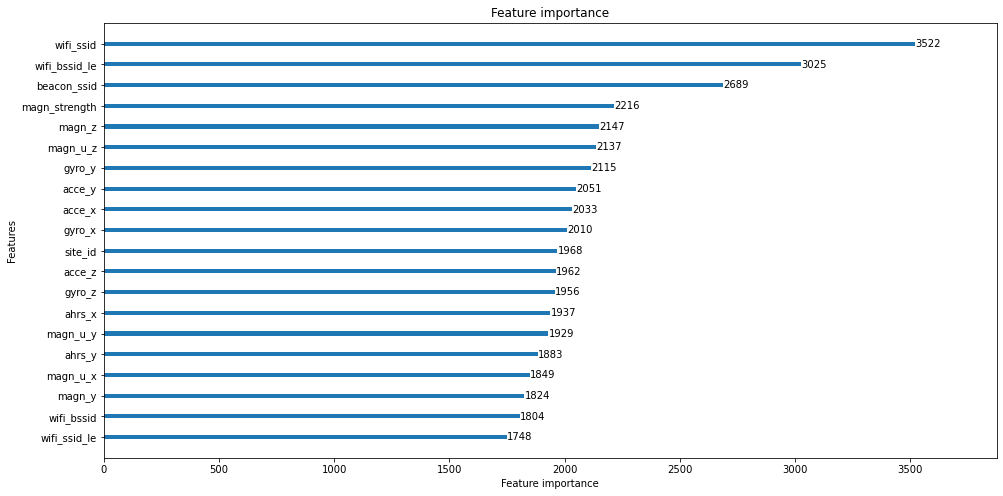

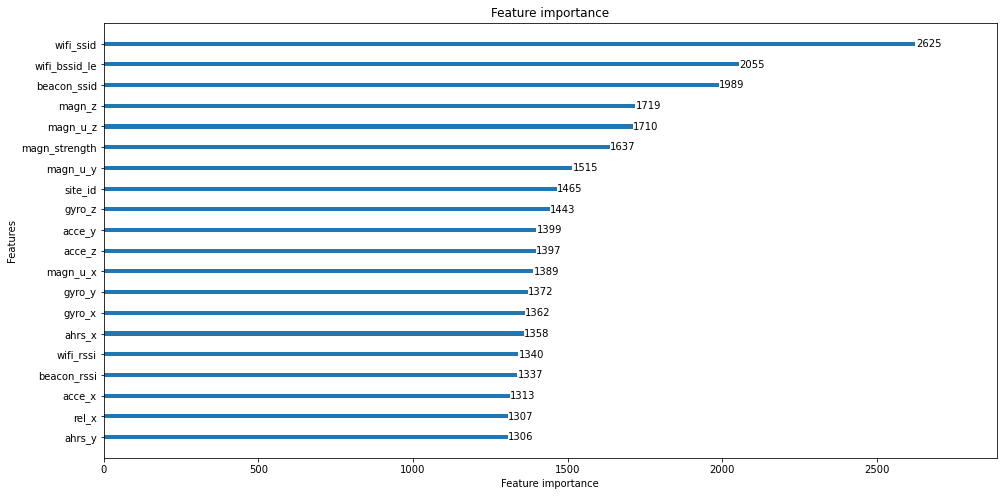

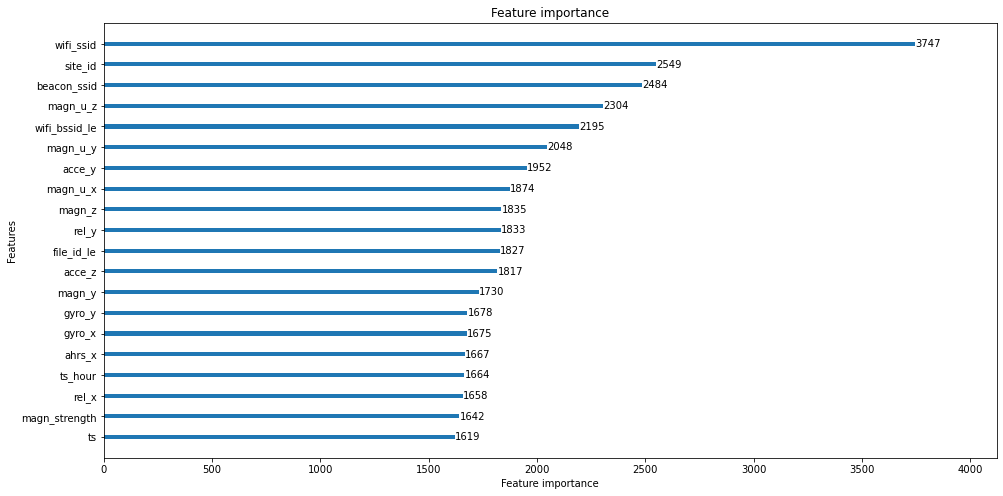

In [183]:
lgb.plot_importance(d["model_x"], max_num_features=20, grid=False, figsize=(16,8))
lgb.plot_importance(d["model_y"], max_num_features=20, grid=False, figsize=(16,8))
lgb.plot_importance(d["model_f"], max_num_features=20, grid=False, figsize=(16,8))

---
## Use the trained model to predict viz data
---

In [184]:
# Run prediction against train data
print(d["feat_viz_x"].shape)
print(d["feat_viz_y"].shape)
print(d["target_viz_x"].shape)

(10581, 67)
(10581, 67)
(10581,)


In [185]:
# Make predictions using the viz data
modelx = d["model_x"]
modely = d["model_y"]
modelf = d["model_f"]

# Make predictions with test data
viz_predsx = modelx.predict(d["feat_viz_x"])
viz_predsy = modely.predict(d["feat_viz_y"])
viz_predsf = modelf.predict(d["feat_viz_f"])

In [186]:
# quick check
# overlap_check = set(d["feat_viz_x"].index) ^ set(d["feat_viz_f"].index)
# print(overlap_check)

df_viz = d["feat_viz_x"]
df_viz["x"] = d["target_viz_x"]
df_viz["y"] = d["target_viz_y"]
df_viz["f"] = d["target_viz_f"]
df_viz["x_pred"] = viz_predsx
df_viz["y_pred"] = viz_predsy
df_viz["f_pred"] = viz_predsf
df_viz["x_diff"] = abs(df_viz["x"] - df_viz["x_pred"])
df_viz["y_diff"] = abs(df_viz["y"] - df_viz["y_pred"])
df_viz["f_diff"] = abs(df_viz["f"] - df_viz["f_pred"])

# create mix of site_id_le x floor
df_viz["site_le_f"] = "site_" + df_viz["site_id_le"].astype(str) + "_floor_" + df_viz["f"].astype(str)

# add difference measurement based on the competition's metric
df_viz["metric"] = np.sqrt((df_viz["x"] - df_viz["x_pred"])**2 + (df_viz["y"] - df_viz["y_pred"])**2) + (15 * abs(df_viz["f"] - df_viz["f_pred"]))

display(df_viz.head())
print(len(viz_predsx))

,site_id,ts,start_ts,diff_start_ts,acce_ts,diff_acce_ts,acce_x,acce_y,acce_z,ahrs_ts,diff_ahrs_ts,ahrs_x,ahrs_y,ahrs_z,magn_ts,diff_magn_ts,magn_x,magn_y,magn_z,magn_strength,gyro_ts,diff_gyro_ts,gyro_x,gyro_y,gyro_z,acce_u_ts,diff_acce_u_ts,acce_u_x,acce_u_y,acce_u_z,magn_u_ts,diff_magn_u_ts,magn_u_x,magn_u_y,magn_u_z,gyro_u_ts,diff_gyro_u_ts,gyro_u_x,gyro_u_y,gyro_u_z,wifi_ts,diff_wifi_ts,wifi_ssid,wifi_bssid,wifi_rssi,wifi_last_seen_ts,beacon_ts,diff_beacon_ts,beacon_ssid,beacon_rssi,rel_ts,diff_rel_ts,rel_x,rel_y,site_id_le,file_id_le,wifi_ssid_le,wifi_bssid_le,beacon_ssid_le,ts_date,ts_day,ts_hour,ts_minute,wifi_last_seen_ts_date,wifi_last_seen_ts_day,wifi_last_seen_ts_hour,wifi_last_seen_ts_minute,x,y,f,x_pred,y_pred,f_pred,x_diff,y_diff,f_diff,site_le_f,metric
40840,5a0546857ecc773753327266,1.578475e+12,1.578475e+12,19.0,1.578475e+12,146.0,-0.195374,4.429993,8.859329,1.578475e+12,146.0,0.176960,0.147564,0.562040,1.578475e+12,146.0,29.173279,-1.922607,-24.125671,37.905470,1.578475e+12,146.0,-0.194672,-0.052048,-0.050400,1578475359815,146,0,4,8,1.578475e+12,146.0,33.299255,6.243896,-363.15002,1578475359815,146,0,0,0,1578475361855,2186,ab150ecf6d972b476aeab16317bed6189d9f7cce,323607d8444900d64151ee06d164738ac727bbce,-45,1578475359755,1578475359780,111,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-80,1.578475e+12,771.0,-0.371389,0.148559,0,26604,6054,5529,13823,1578475359688000000,1578441600000000000,1578474000000000000,1578475320000000000,1578475359755000064,1578441600000000000,1578474000000000000,1578475320000000000,102.662500,76.862010,0,96.069033,75.783264,-0.026128,6.593467,1.078746,0.026128,site_0_floor_0,7.073052
143918,5dbc1d84c1eb61796cf7c010,1.574254e+12,1.574254e+12,8472.0,1.574254e+12,8470.0,-0.485123,-0.924194,10.866196,1.574254e+12,8470.0,-0.036235,-0.040263,0.993455,1.574254e+12,8470.0,4.261780,-12.594605,-19.941711,23.967867,1.574254e+12,8470.0,-0.006943,-0.315079,0.083786,1574254184904,8470,0,0,10,1.574254e+12,8470.0,-36.769104,-137.362670,-317.72766,1574254184904,8470,0,0,0,1574254184161,7727,8f7d5669fb8464cd2eef926f246adaac8050b848,769eeca6ded625ba26d269ad5aeb325ab213db10,-43,1574254157428,1574254184721,8287,89cb11b04122cef23388b0da06bd426c1f48a9b5_cf6a3...,-85,1.574254e+12,8470.0,-0.125337,-0.621656,202,24709,5023,13192,10717,1574254184905999872,1574208000000000000,1574251200000000000,1574254140000000000,1574254157428000000,1574208000000000000,1574251200000000000,1574254140000000000,179.955640,61.736046,5,154.874525,105.677385,4.581645,25.081115,43.941339,0.418355,site_202_floor_5,56.870817
40730,5a0546857ecc773753327266,1.578477e+12,1.578477e+12,17231.0,1.578477e+12,17240.0,0.491165,4.290543,8.480453,1.578477e+12,17240.0,0.253429,-0.164088,-0.621925,1.578477e+12,17240.0,-28.388977,-11.137390,-25.593567,39.812136,1.578477e+12,17240.0,-0.213837,-0.161774,-0.295929,1578477223488,17240,0,4,8,1.578477e+12,17240.0,-27.056885,-2.081299,-365.17487,1578477223488,17240,0,0,0,1578477224615,18367,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,5df57fca60cb48fac97a573ea4f2bd3a85f045f4,-49,1578477223579,1578477223393,17145,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-87,1.578477e+12,17422.0,0.456207,0.012108,0,26671,7731,10430,13823,1578477223479000064,1578441600000000000,1578474000000000000,1578477180000000000,1578477223579000064,1578441600000000000,1578474000000000000,1578477180000000000,82.560680,37.360947,0,69.105342,49.940698,-0.067544,13.455338,12.579751,0.067544,site_0_floor_0,19.433163
33335,5da1389e4db8ce0c98bd0547,1.573269e+12,1.573269e+12,106789.0,1.573269e+12,106793.0,-0.835052,4.171051,6.339966,1.573269e+12,106793.0,-0.050352,0.202481,0.976637,1.573269e+12,106793.0,5.029297,-42.657470,-16.725159,46.094300,1.573269e+12,106793.0,0.095734,-0.254944,0.335770,1573268729302,106793,-1,4,6,1.573269e+12,106793.0,-35.588074,-54.435730,-360.10284,1573268729302,106793,0,0,0,1573268729741,107232,0e41516011e82dba712d3fd8e76ad7fa560aa51c,cc7126e6b9242e07a8074aa05c7083fa4dbd865d,-63,1573268720313,1573268689239,66730

10581


In [187]:
# set sites with most/mid/least counts
site_le_f_counts = df_viz["site_le_f"].value_counts()
site_most_count = site_le_f_counts.idxmax()
site_least_count = site_le_f_counts.idxmin()
site_mid_count = int(len(site_le_f_counts) / 2)
site_count_list = df_viz["site_le_f"].value_counts().index.tolist()

print("site_floor with most count: ", site_most_count, "->", site_le_f_counts[site_most_count])
print("site_floor with mid count: ", site_count_list[site_mid_count], "->", site_le_f_counts[site_count_list[site_mid_count]])
print("site_floor with least count: ", site_least_count, "->", site_le_f_counts[site_least_count])

site_floor with most count:  site_180_floor_0 -> 344
site_floor with mid count:  site_201_floor_3 -> 66
site_floor with least count:  site_192_floor_2 -> 4


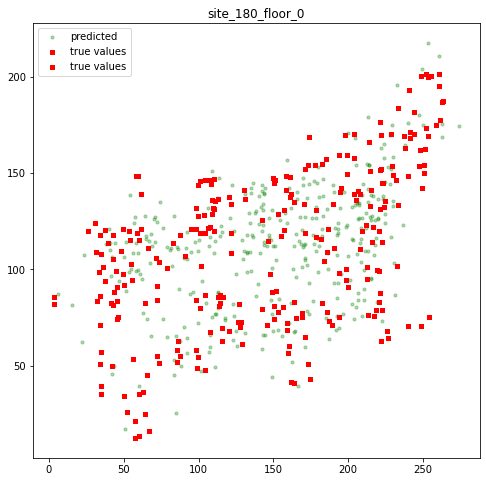

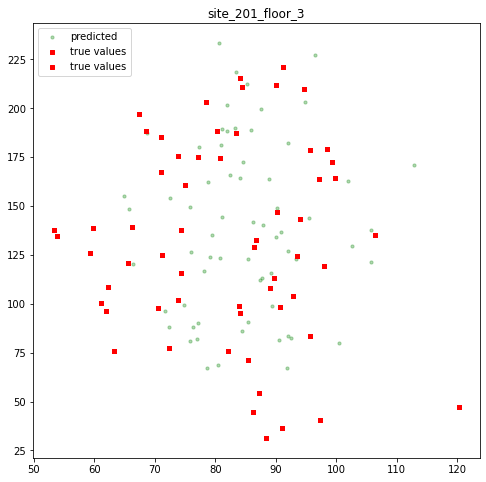

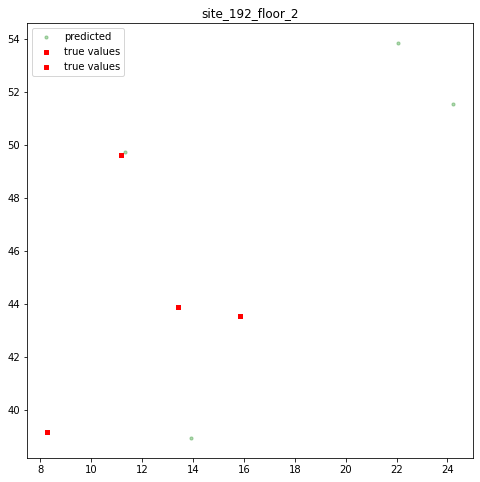

In [188]:
x_max = df_viz["x"].max()
x_min = df_viz["x"].min()
y_max = df_viz["y"].max()
y_min = df_viz["y"].min()

# Plot predictions against ground truths
def plot_gt_pred(site, scale=True):
    df_viz_a = df_viz[df_viz["site_le_f"] == site] # most counts
    x = df_viz_a["x"]
    y = df_viz_a["y"]
    x_pred = df_viz_a["x_pred"]
    y_pred = df_viz_a["y_pred"]

    fig = plt.figure(figsize=(8,8))
    fig.patch.set_facecolor("white")
    ax1 = fig.add_subplot(111)
    ax1.scatter(x_pred, y_pred, s=10, c="g", marker="o", label="predicted", alpha=0.3)
    ax1.scatter(x, y, s=10, c="r", marker="s", label="true values")
    ax1.scatter(x, y, s=10, c="r", marker="s", label="true values")
    if scale == True:
        ax1.set_xlim([x_min, x_max])
        ax1.set_ylim([y_min, y_max])
    ax1.set_title(site)
    plt.legend(loc='upper left');
    plt.show()

plot_gt_pred(site_most_count, scale=False)
plot_gt_pred(site_count_list[site_mid_count], scale=False)
plot_gt_pred(site_least_count, scale=False)

# plot_gt_pred(site_most_count, scale=True)
# plot_gt_pred(site_count_list[site_mid_count], scale=True)
# plot_gt_pred(site_least_count, scale=True)

In [189]:
# Take difference of truth - predicted -> which has the largest difference
display(df_viz.head())
print(len(df_viz))
print(df_viz["ts"].nunique())

# # train 2
# df_viz_grouped = df_viz.groupby("site_le_f").agg({"site_le_f": "count", \
#                                                   "closest_wp_ts": lambda x: x.nunique(), \
#                                                   "x_diff": "mean", "y_diff": "mean", \
#                                                   "f_diff": "mean", "metric": "mean"
#                                                  })
# df_viz_grouped = df_viz_grouped.sort_values(by=["closest_wp_ts"], ascending=False)

# train 3
df_viz_grouped = df_viz.groupby("site_le_f").agg({"site_le_f": "count", \
                                                  "ts": lambda x: x.nunique(), \
                                                  "x_diff": "mean", "y_diff": "mean", \
                                                  "f_diff": "mean", "metric": "mean"
                                                 })
df_viz_grouped = df_viz_grouped.sort_values(by=["ts"], ascending=False)
print(len(df_viz_grouped))
display(df_viz_grouped)

,site_id,ts,start_ts,diff_start_ts,acce_ts,diff_acce_ts,acce_x,acce_y,acce_z,ahrs_ts,diff_ahrs_ts,ahrs_x,ahrs_y,ahrs_z,magn_ts,diff_magn_ts,magn_x,magn_y,magn_z,magn_strength,gyro_ts,diff_gyro_ts,gyro_x,gyro_y,gyro_z,acce_u_ts,diff_acce_u_ts,acce_u_x,acce_u_y,acce_u_z,magn_u_ts,diff_magn_u_ts,magn_u_x,magn_u_y,magn_u_z,gyro_u_ts,diff_gyro_u_ts,gyro_u_x,gyro_u_y,gyro_u_z,wifi_ts,diff_wifi_ts,wifi_ssid,wifi_bssid,wifi_rssi,wifi_last_seen_ts,beacon_ts,diff_beacon_ts,beacon_ssid,beacon_rssi,rel_ts,diff_rel_ts,rel_x,rel_y,site_id_le,file_id_le,wifi_ssid_le,wifi_bssid_le,beacon_ssid_le,ts_date,ts_day,ts_hour,ts_minute,wifi_last_seen_ts_date,wifi_last_seen_ts_day,wifi_last_seen_ts_hour,wifi_last_seen_ts_minute,x,y,f,x_pred,y_pred,f_pred,x_diff,y_diff,f_diff,site_le_f,metric
40840,5a0546857ecc773753327266,1.578475e+12,1.578475e+12,19.0,1.578475e+12,146.0,-0.195374,4.429993,8.859329,1.578475e+12,146.0,0.176960,0.147564,0.562040,1.578475e+12,146.0,29.173279,-1.922607,-24.125671,37.905470,1.578475e+12,146.0,-0.194672,-0.052048,-0.050400,1578475359815,146,0,4,8,1.578475e+12,146.0,33.299255,6.243896,-363.15002,1578475359815,146,0,0,0,1578475361855,2186,ab150ecf6d972b476aeab16317bed6189d9f7cce,323607d8444900d64151ee06d164738ac727bbce,-45,1578475359755,1578475359780,111,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-80,1.578475e+12,771.0,-0.371389,0.148559,0,26604,6054,5529,13823,1578475359688000000,1578441600000000000,1578474000000000000,1578475320000000000,1578475359755000064,1578441600000000000,1578474000000000000,1578475320000000000,102.662500,76.862010,0,96.069033,75.783264,-0.026128,6.593467,1.078746,0.026128,site_0_floor_0,7.073052
143918,5dbc1d84c1eb61796cf7c010,1.574254e+12,1.574254e+12,8472.0,1.574254e+12,8470.0,-0.485123,-0.924194,10.866196,1.574254e+12,8470.0,-0.036235,-0.040263,0.993455,1.574254e+12,8470.0,4.261780,-12.594605,-19.941711,23.967867,1.574254e+12,8470.0,-0.006943,-0.315079,0.083786,1574254184904,8470,0,0,10,1.574254e+12,8470.0,-36.769104,-137.362670,-317.72766,1574254184904,8470,0,0,0,1574254184161,7727,8f7d5669fb8464cd2eef926f246adaac8050b848,769eeca6ded625ba26d269ad5aeb325ab213db10,-43,1574254157428,1574254184721,8287,89cb11b04122cef23388b0da06bd426c1f48a9b5_cf6a3...,-85,1.574254e+12,8470.0,-0.125337,-0.621656,202,24709,5023,13192,10717,1574254184905999872,1574208000000000000,1574251200000000000,1574254140000000000,1574254157428000000,1574208000000000000,1574251200000000000,1574254140000000000,179.955640,61.736046,5,154.874525,105.677385,4.581645,25.081115,43.941339,0.418355,site_202_floor_5,56.870817
40730,5a0546857ecc773753327266,1.578477e+12,1.578477e+12,17231.0,1.578477e+12,17240.0,0.491165,4.290543,8.480453,1.578477e+12,17240.0,0.253429,-0.164088,-0.621925,1.578477e+12,17240.0,-28.388977,-11.137390,-25.593567,39.812136,1.578477e+12,17240.0,-0.213837,-0.161774,-0.295929,1578477223488,17240,0,4,8,1.578477e+12,17240.0,-27.056885,-2.081299,-365.17487,1578477223488,17240,0,0,0,1578477224615,18367,d839a45ebe64ab48b60a407d837fb01d3c0dfef9,5df57fca60cb48fac97a573ea4f2bd3a85f045f4,-49,1578477223579,1578477223393,17145,d9c573b719a17da4836208fc436f87b5ca1aa877_b6589...,-87,1.578477e+12,17422.0,0.456207,0.012108,0,26671,7731,10430,13823,1578477223479000064,1578441600000000000,1578474000000000000,1578477180000000000,1578477223579000064,1578441600000000000,1578474000000000000,1578477180000000000,82.560680,37.360947,0,69.105342,49.940698,-0.067544,13.455338,12.579751,0.067544,site_0_floor_0,19.433163
33335,5da1389e4db8ce0c98bd0547,1.573269e+12,1.573269e+12,106789.0,1.573269e+12,106793.0,-0.835052,4.171051,6.339966,1.573269e+12,106793.0,-0.050352,0.202481,0.976637,1.573269e+12,106793.0,5.029297,-42.657470,-16.725159,46.094300,1.573269e+12,106793.0,0.095734,-0.254944,0.335770,1573268729302,106793,-1,4,6,1.573269e+12,106793.0,-35.588074,-54.435730,-360.10284,1573268729302,106793,0,0,0,1573268729741,107232,0e41516011e82dba712d3fd8e76ad7fa560aa51c,cc7126e6b9242e07a8074aa05c7083fa4dbd865d,-63,1573268720313,1573268689239,66730

10581
10581
139


,site_le_f,ts,x_diff,y_diff,f_diff,metric
site_le_f,,,,,,
site_180_floor_0,344,344.0,21.922387,17.448537,0.142018,32.325331
site_180_floor_1,257,257.0,22.035780,14.870064,0.217801,32.188247
site_180_floor_2,229,229.0,19.776585,14.128846,0.167539,29.172758
site_189_floor_-1,184,184.0,13.209090,13.948973,0.104004,22.539374
site_196_floor_0,180,180.0,17.566301,14.625819,0.143633,27.194567
...,...,...,...,...,...,...
site_189_floor_2,10,10.0,9.539643,8.826714,0.158540,16.104206
site_182_floor_4,9,9.0,10.717434,12.962818,0.081769,19.625039
site_180_floor_5,9,9.0,17.379511,6.686580,0.068285,20.182868


supposed_comp_metric:  28.43789274033388


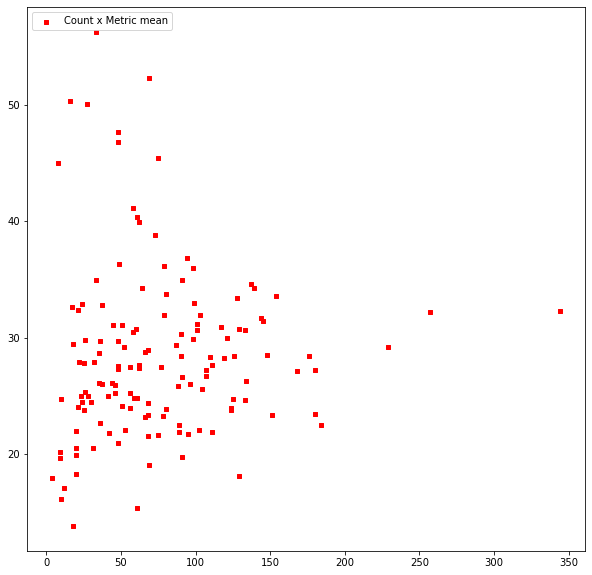

In [190]:
supposed_comp_metric = df_viz_grouped["metric"].mean()
print("supposed_comp_metric: ", supposed_comp_metric)

# Visualize count and comp metric
a = df_viz_grouped["site_le_f"]
b = df_viz_grouped["metric"]

fig = plt.figure(figsize=(10,10))
fig.patch.set_facecolor("white")
ax1 = fig.add_subplot(111)
ax1.scatter(a, b, s=10, c="r", marker="s", label="Count x Metric mean")
plt.legend(loc='upper left');
plt.show()

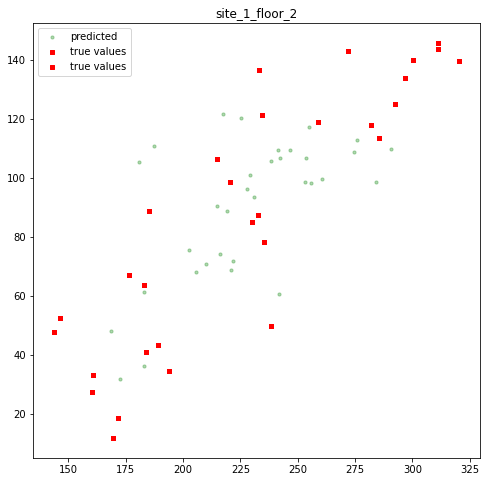

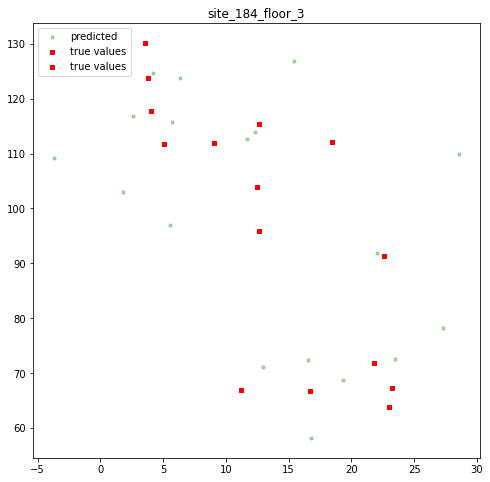

In [191]:
# Try seeing other sites with high metric mean
metric_higest = df_viz_grouped["metric"].idxmax()
metric_lowest = df_viz_grouped["metric"].idxmin()

plot_gt_pred(metric_higest, scale=False)
plot_gt_pred(metric_lowest, scale=False)

In [ ]:
# Plot ground truth and predictions on actual map
# Low metric mean -> waypoints are scattered, and intervals seem sparce
# Set scales right for all graphs

---
## Making Quick Prediction
---

In [ ]:
test_file_name = "../input/indoorfulltestgroupedtrain/indoor_test_2_250ms.pkl"

with open(test_file_name, "rb") as file:
    df_test = pickle.load(file)

In [ ]:
display(df_test.head())

In [ ]:
print(len(df_test.columns))
# df_test = df_test.dropna(axis=1, how='all')
df_test = df_test.dropna(axis=1, how='all')
df_test = df_test.dropna(axis=0, how='any')
print(len(df_test.columns))

null_cols = df_test.columns[df_test.isna().any()].tolist()
print("Columns with nulls: ", null_cols)

def fill_na_mean(df, cols, groupby_col):
    for col in cols:
        df[col] = df.groupby(groupby_col).transform(lambda x: x.fillna(x.mean()))

# 4 min for 100,000 rows
# fill_na_mean(df_test, tqdm(null_cols), "site_id")

# null_cols = df_test.columns[df_test.isna().any()].tolist()
# print("Check if nulls are filled: ", null_cols)


# column settings
# rename within_250ms and within_500ms first
# df_test = df_test.rename({"within_250ms": "within_100ms", "within_500ms": "within_200ms"}, axis=1)

# latter is to drop all the ts related columns
# drop_cols = ["floor_converted", "floor", "x", "y", "floor_le", "file_id", "file_id_le", "diff_start_wp_ts"]
# drop_cols = ["floor_converted", "floor", "x", "y", "floor_le", "file_id", "file_id_le", \
#              "ts", "start_ts", "diff_start_ts", "closest_wp_ts", "diff_start_wp_ts", "diff_ts_wp_ts", \
#              "acce_ts", "diff_acce_ts", "ahrs_ts", "diff_ahrs_ts", "magn_ts", "diff_magn_ts", \
#              "gyro_ts", "diff_gyro_ts", "acce_u_ts", "diff_acce_u_ts", "magn_u_ts", "diff_magn_u_ts", \
#              "gyro_u_ts", "diff_gyro_u_ts", "wifi_ts", "diff_wifi_ts", "wifi_last_seen_ts", \
#              "beacon_ts", "diff_beacon_ts", "rel_ts", "diff_rel_ts", "ts_date", "ts_day", \
#              "ts_hour", "ts_minute", "wifi_last_seen_ts_date", "wifi_last_seen_ts_day", \
#              "wifi_last_seen_ts_hour", "wifi_last_seen_ts_minute"
#             ]

# categorical_features = ["site_id", "within_100ms", "within_200ms", "wifi_ssid", "wifi_bssid", "beacon_ssid"]
categorical_features = ["site_id", "within_250ms", "within_500ms", "wifi_ssid", "wifi_bssid", "beacon_ssid"]
int_features = ["acce_u_ts", "diff_acce_u_ts", "acce_u_x", "acce_u_y", "acce_u_z",\
                "gyro_u_ts", "diff_gyro_u_ts", "gyro_u_x", "gyro_u_y", "gyro_u_z",\
                "wifi_rssi", "wifi_ts", "diff_wifi_ts", "wifi_last_seen_ts", 
                "beacon_rssi", "beacon_ts", "diff_beacon_ts", \
                "ts_date", "ts_day", "ts_hour", "ts_minute", \
                "wifi_last_seen_ts_date", "wifi_last_seen_ts_day", \
                "wifi_last_seen_ts_hour", "wifi_last_seen_ts_minute"]

# convert to category from object dtype
for col in categorical_features:
    df_test[col] = df_test[col].astype("category")

# convert to int from datetime64 dtype
for col in int_features:
    df_test[col] = df_test[col].astype(int)

# drop cols
drop_cols = ["file_id", "floor_le"]
df_test = df_test.drop(columns=drop_cols)
test_features = df_test.set_index("site_path_timestamp")

In [ ]:
print(len(df_test))
print("site_id nunique: ", df_test["site_id"].nunique(), "\n")
display(test_features.head())
print(len(features.columns))
print(len(test_features.columns))
no_overlap = set(features.columns) ^ set(test_features.columns)
# a = list(set(features.columns) & set(test_features.columns))
print(no_overlap)
# print(features.dtypes[:50])
# print(test_features.dtypes[:50])

In [ ]:
# Load models
modelx = d["model_x"]
modely = d["model_y"]
modelf = d["model_f"]

# Make predictions with test data
test_predsx = modelx.predict(test_features)
test_predsy = modely.predict(test_features)
test_predsf = modelf.predict(test_features)

In [ ]:
df_preds = pd.DataFrame(np.stack((test_features.index, test_predsf, test_predsx, test_predsy))).T
df_preds.columns = ["site_path_timestamp", "floor", "x", "y"]
# test_preds = test_preds.set_index("site_path_timestamp")
print("df_preds before groupby: ")
display(df_preds.head())

# groupby to take the average
# convert to float from object
for col in ["floor", "x", "y"]:
    df_preds[col] = df_preds[col].astype(float)

df_pred_grouped = df_preds.groupby(["site_path_timestamp"]).mean()
df_pred_grouped = df_pred_grouped.reset_index()

# round floor value to integer
df_pred_grouped["floor"] = df_pred_grouped["floor"].round(decimals=0)

print("len of df_pred_grouped: ", len(df_pred_grouped)) # should be same as sub_df length, but not yet
print("df_pred_grouped after groupby: ")
display(df_pred_grouped.head())

# find the missing site_path_timestamp and fill it with average
# get submission file
sub_df = pd.read_csv("/kaggle/input/indoor-location-navigation/sample_submission.csv")
print("sub_df: ")
display(sub_df.head())

subdf_site_id = sub_df["site_path_timestamp"].unique()
pred_site_id = df_pred_grouped["site_path_timestamp"].unique()
print("len of subdf_site_id", len(subdf_site_id), "\n")
print("len of pred_site_id", len(pred_site_id), "\n")
no_overlap = set(subdf_site_id) ^ set(pred_site_id)
print("no overlap", no_overlap)

# missing timestamps -> fill in with average value for now
# '5dbc1d84c1eb61796cf7c010_67bf4b03fc22542bb6d51daf_0000000000011'
# '5d2709e003f801723c32d896_e3455e53350336857caf08f0_0000000119903'
floor_avg = round(df_pred_grouped["floor"].mean())
x_avg = df_pred_grouped["x"].mean()
y_avg = df_pred_grouped["y"].mean()
print("avg values for floor, x, y", floor_avg, x_avg, y_avg)

for i, ts in enumerate(list(no_overlap)):
    row = [ts, floor_avg, x_avg, y_avg]
    row_num = len(df_pred_grouped)
    df_pred_grouped.loc[row_num + i] = row

print("len of pred_grouped", len(df_pred_grouped))
print("tail of df_pred_grouped to check missing two rows are appended: ")
display(df_pred_grouped.tail())

In [ ]:
# csv for submission
df_pred_grouped.to_csv("submission.csv", index=False)